In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
s

In [18]:
df = pd.read_csv('AAPL.csv')

In [19]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,175.690002,177.750000,173.970001,175.850006,173.578033,27436200
1,2019-03-05,175.940002,176.000000,174.539993,175.529999,173.262161,19737400
2,2019-03-06,174.669998,175.490005,173.940002,174.520004,172.265228,20810400
3,2019-03-07,173.869995,174.440002,172.020004,172.500000,170.271317,24796400
4,2019-03-08,170.320007,173.070007,169.500000,172.910004,170.676025,23999400


In [20]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [21]:
df.index

DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-15',
               ...
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', name='Date', length=253, freq=None)

In [22]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

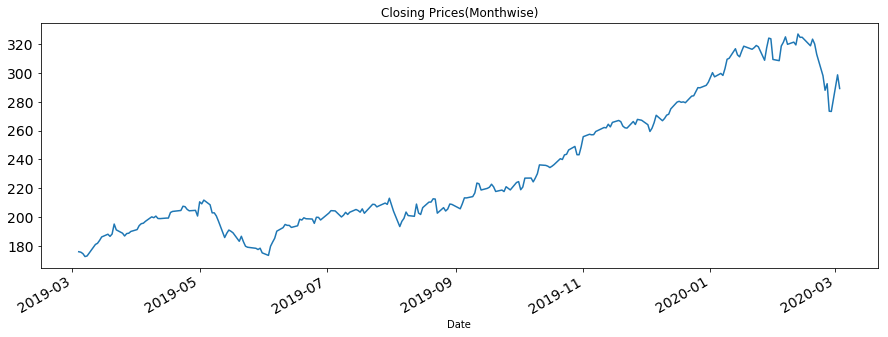

In [23]:
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(15,5), title= 'Closing Prices(Monthwise)', fontsize=14)

In [24]:
df.shape

(253, 9)

In [25]:
test = df[200:]
train = df[:199]

In [26]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
 
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] = values
        print(output)

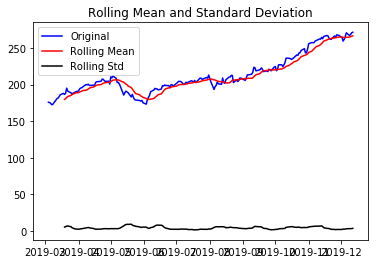

Results of dickey fuller test
Test Statistics                  0.029984
p-value                          0.960943
No. of lags used                 0.000000
Number of observations used    198.000000
critical value (1%)             -3.463815
dtype: float64
Test Statistics                  0.029984
p-value                          0.960943
No. of lags used                 0.000000
Number of observations used    198.000000
critical value (1%)             -3.463815
critical value (5%)             -2.876251
dtype: float64
Test Statistics                  0.029984
p-value                          0.960943
No. of lags used                 0.000000
Number of observations used    198.000000
critical value (1%)             -3.463815
critical value (5%)             -2.876251
critical value (10%)            -2.574611
dtype: float64


In [27]:
 test_stationarity(train['Close'])

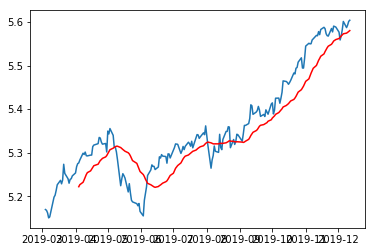

In [28]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])
moving_avg = train_log.rolling(24).mean() 
plt.plot(train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

In [29]:
train_log_moving_avg_diff = train_log - moving_avg

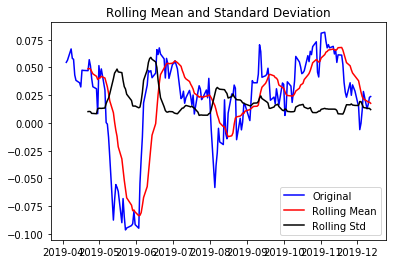

Results of dickey fuller test
Test Statistics                 -3.495580
p-value                          0.008101
No. of lags used                 9.000000
Number of observations used    166.000000
critical value (1%)             -3.470370
dtype: float64
Test Statistics                 -3.495580
p-value                          0.008101
No. of lags used                 9.000000
Number of observations used    166.000000
critical value (1%)             -3.470370
critical value (5%)             -2.879114
dtype: float64
Test Statistics                 -3.495580
p-value                          0.008101
No. of lags used                 9.000000
Number of observations used    166.000000
critical value (1%)             -3.470370
critical value (5%)             -2.879114
critical value (10%)            -2.576139
dtype: float64


(None, None)

In [30]:
train_log_moving_avg_diff.dropna(inplace = True), test_stationarity(train_log_moving_avg_diff)


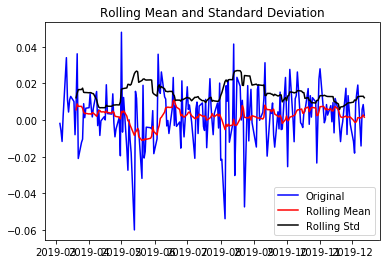

Results of dickey fuller test
Test Statistics               -1.427582e+01
p-value                        1.349875e-26
No. of lags used               0.000000e+00
Number of observations used    1.970000e+02
critical value (1%)           -3.463987e+00
dtype: float64
Test Statistics               -1.427582e+01
p-value                        1.349875e-26
No. of lags used               0.000000e+00
Number of observations used    1.970000e+02
critical value (1%)           -3.463987e+00
critical value (5%)           -2.876326e+00
dtype: float64
Test Statistics               -1.427582e+01
p-value                        1.349875e-26
No. of lags used               0.000000e+00
Number of observations used    1.970000e+02
critical value (1%)           -3.463987e+00
critical value (5%)           -2.876326e+00
critical value (10%)          -2.574652e+00
dtype: float64


In [31]:
train_log_diff = train_log - train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-1088.057, BIC=-1068.327, Time=0.263 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-1092.033, BIC=-1085.456, Time=0.035 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-1090.127, BIC=-1080.262, Time=0.028 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-1090.151, BIC=-1080.286, Time=0.031 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-1089.952, BIC=-1086.664, Time=0.043 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-1088.651, BIC=-1075.498, Time=0.066 seconds
Total fit time: 0.484 seconds


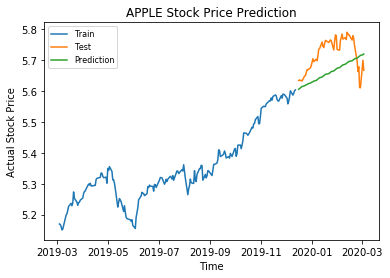

In [36]:
model = pm.auto_arima(train_log, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_log)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test_log.index,columns=['Prediction'])
#plot the predictions for validation set
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()